<a href="https://colab.research.google.com/github/Token-05/FACERecognition/blob/main/facerecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U keras 
!pip install tensorflow
!pip list

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.11.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0


Package                       Version
----------------------------- ----------------------
absl-py                       1.3.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.3
aiosignal                     1.3.1
alabaster                     0.7.12
albumentations                1.2.1
altair                        4.2.0
appdirs                       1.4.4
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.2.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.11.0
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.1
blis                          0.7.9
bokeh                         2.3.3
branca

In [ ]:
# 入力処理系
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
# ネットワーク系
import torch.nn as nn
import torch
import tensorflow as tf
from keras import models
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Activation, Flatten, Dropout, Lambda, ELU, concatenate, GlobalAveragePooling2D, Input, BatchNormalization, SeparableConv2D, Subtract, concatenate, Conv2D, AveragePooling2D
from keras.activations import relu, softmax
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# version 1.0 (～中間発表)
# network : squeezenet(今のところ最速の学習率)
class faceid_beta:
    # 初期化
    def __init__(self):
        pass
    
    # 同一人物の画像カップル
    def create_couple_rgbd(self, folder_name):
        # ファイルパス
        if folder_name == 'train':
          under_vap_path, under_cap_path, under_cap_path2 = random.randint(1, 40), random.randint(1, 100), random.randint(1, 100)
        elif folder_name == 'val':
          under_vap_path, under_cap_path, under_cap_path2 = random.randint(41, 51), random.randint(1, 100), random.randint(1, 100)
        # rgb(sync)
        im1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path,under_cap_path)))[140:340,220:420]
        im2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path,under_cap_path2)))[140:340,220:420]
        # d(sync)
        imd1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncD/{}.png'.format(under_vap_path,under_cap_path)))[140:340,220:420]
        imd2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncD/{}.png'.format(under_vap_path,under_cap_path2)))[140:340,220:420]
        # 正規化
        im1_truth = (imd1-np.mean(imd1))/np.max(imd1)
        im2_truth = (imd2-np.mean(imd2))/np.max(imd2)
        # 元の画像がRGBなのでRGBDに作り替える
        full1 = np.zeros((200,200,4))
        full1[:,:,:3] = im1[:,:,:3]
        full1[:,:,3] = im1_truth
        full2 = np.zeros((200,200,4))
        full2[:,:,:3] = im2[:,:,:3]
        full2[:,:,3] = im2_truth
        return np.array([full1, full2])
    
    # 同一人物でない画像カップル
    def create_wrong_rgbd(self, folder_name):
        # ファイルパス
        if folder_name == 'train':
          under_vap_path, under_cap_path = random.sample(list(range(1,41)),2), random.sample(list(range(1,101)),2)
        elif folder_name == 'val':
          under_vap_path, under_cap_path = random.sample(list(range(41,52)),2), random.sample(list(range(1,101)),2)
        # rgb(sync)
        im1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path[0],under_cap_path[0])))[140:340,220:420]
        im2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path[1],under_cap_path[1])))[140:340,220:420]
        # d(sync)
        imd1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncD/{}.png'.format(under_vap_path[0],under_cap_path[0])))[140:340,220:420]
        imd2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncD/{}.png'.format(under_vap_path[1],under_cap_path[1])))[140:340,220:420]
        # 正規化
        im1_truth = (imd1-np.mean(imd1))/np.max(imd1)
        im2_truth = (imd2-np.mean(imd2))/np.max(imd2)
        # 元の画像がRGBなのでRGBDに作り替える
        full1 = np.zeros((200,200,4))
        full1[:,:,:3] = im1[:,:,:3]
        full1[:,:,3] = im1_truth
        full2 = np.zeros((200,200,4))
        full2[:,:,:3] = im2[:,:,:3]
        full2[:,:,3] = im2_truth
        return np.array([full1, full2])
    
    # ユークリッド距離の導出(顔の類似度チェック)
    def euclidean_distance(self, inputs):
        assert len(inputs) == 2, 'Euclidean distance needs 2 inputs, %d given' % len(inputs)
        u, v = inputs
        return K.sqrt(K.sum((K.square(u - v)), axis=1, keepdims=True))
    
    # 対となるサンプル同士の近傍・分離
    def contrastive_loss(self,y_true,y_pred):
        margin=1.0
        return K.mean((margin - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0.0)))
        # return K.mean( K.square(y_pred) )
    
    # inception module (https://pystyle.info/pytorch-googlenet/#outline__2_2)
    def fire(self, x, squeeze=16, expand=64):
        x = Conv2D(squeeze, (1,1), padding='valid', activation='relu')(x)
        # 1x1だと端のデータも特徴量として算出しやすい
        left = Conv2D(expand, (1,1), padding='valid', activation='relu')(x)
        # 3x3だと厳しいのでゼロパディングして端のデータに対して調整
        right = Conv2D(expand, (3,3), padding='same', activation='relu')(x)
        # 合体
        x = concatenate([left, right], axis=3)
        return x
    
    # 畳み込み
    def convolution(self):
      img_input=Input(shape=(200,200,4))
      x = Conv2D(64, (5, 5), strides=(2, 2), padding='valid')(img_input)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
      x = self.fire(x, squeeze=16, expand=16)
      x = self.fire(x, squeeze=16, expand=16)
      x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
      x = self.fire(x, squeeze=32, expand=32)
      x = self.fire(x, squeeze=32, expand=32)
      x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
      x = self.fire(x, squeeze=48, expand=48)
      x = self.fire(x, squeeze=48, expand=48)
      x = self.fire(x, squeeze=64, expand=64)
      x = self.fire(x, squeeze=64, expand=64)
      x = Dropout(0.2)(x)
      x = Conv2D(512, (1, 1), padding='same')(x)
      out = Activation('relu')(x)
      modelsqueeze= Model(img_input, out)
      modelsqueeze.summary()
      im_in = Input(shape=(200,200,4))
      x1 = modelsqueeze(im_in)
      x1 = Flatten()(x1)
      x1 = Dense(512, activation="relu")(x1)
      x1 = Dropout(0.2)(x1)
      x1 = BatchNormalization()(x1)
      feat_x = Dense(128, activation="linear")(x1)
      feat_x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(feat_x)
      model_top = Model(inputs = [im_in], outputs = feat_x)
      model_top.summary()
      im_in1 = Input(shape=(200,200,4))
      im_in2 = Input(shape=(200,200,4))
      feat_x1 = model_top(im_in1)
      feat_x2 = model_top(im_in2)
      lambda_merge = Lambda(self.euclidean_distance)([feat_x1, feat_x2])
      model_final = Model(inputs = [im_in1, im_in2], outputs = lambda_merge)
      model_final.summary()
      adam = Adam(learning_rate=0.001)
      model_final.compile(optimizer=adam, loss=self.contrastive_loss, metrics=['accuracy'])
      return model_final
    
    def show_graph(self):
      gen = self.generator(32)
      val_gen = self.val_generator(8)
      model_final = self.convolution()
      checkpoint = ModelCheckpoint(filepath = "/content/drive/MyDrive/ColabNotebooks/graduation_research/main/model_best3",save_best_only=True)
      history = model_final.fit(gen, steps_per_epoch=80, epochs=50, validation_data = val_gen, validation_steps=20, callbacks=[checkpoint])

      plt.plot(history.history['accuracy'])
      plt.plot(history.history['val_accuracy'])
      plt.title('Model accuracy')
      plt.ylabel('Accuracy')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Validation'], loc='upper left')
      plt.show()

      # Plot training & validation loss values
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('Model loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Validation'], loc='upper left')
      plt.show()

      return model_final
    
    # train data set (訓練データ)
    def generator(self, batch_size):
        while 1:
            X=[]
            y=[]
            switch=True
            for _ in range(batch_size):
                if switch:
                #   print("correct")
                    X.append(self.create_couple_rgbd('train').reshape((2,200,200,4)))
                    y.append(np.array([0.]))
                else:
                #   print("wrong")
                    X.append(self.create_wrong_rgbd('train').reshape((2,200,200,4)))
                    y.append(np.array([1.]))
                switch=not switch
            X = np.asarray(X)
            y = np.asarray(y)
            XX1=X[0,:]
            XX2=X[1,:]
            yield [X[:,0],X[:,1]],y
    
    # val data set (検証用データ)
    def val_generator(self, batch_size):
        while 1:
            X=[]
            y=[]
            switch=True
            for _ in range(batch_size):
                if switch:
                    X.append(self.create_couple_rgbd('val').reshape((2,200,200,4)))
                    y.append(np.array([0.]))
                else:
                    X.append(self.create_wrong_rgbd('val').reshape((2,200,200,4)))
                    y.append(np.array([1.]))
                switch=not switch
            X = np.asarray(X)
            y = np.asarray(y)
            XX1=X[0,:]
            XX2=X[1,:]
            yield [X[:,0],X[:,1]],y

In [ ]:
# version 1.1 (～年末)
# network : googlenet(深すぎて学習率悪い)
class faceid_v1_1:
  # 初期化
  def __init__(self):
    pass
  
  # 同一人物の画像カップル
  def create_couple_rgbd(self, folder_name):
    # ファイルパスの設定
    if folder_name == 'train':
      under_vap_path, under_cap_path, under_cap_path2 = random.randint(1, 40), random.randint(1, 100), random.randint(1, 100)
    elif folder_name == 'val':
      under_vap_path, under_cap_path, under_cap_path2 = random.randint(41, 51), random.randint(1, 100), random.randint(1, 100)
    # rgb(sync)
    im1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path,under_cap_path)))[140:340,220:420]
    im2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path,under_cap_path2)))[140:340,220:420]
    # d(sync)
    imd1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncD/{}.png'.format(under_vap_path,under_cap_path)))[140:340,220:420]
    imd2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncD/{}.png'.format(under_vap_path,under_cap_path2)))[140:340,220:420]
    # 正規化
    im1_truth = (imd1-np.mean(imd1))/np.max(imd1)
    im2_truth = (imd2-np.mean(imd2))/np.max(imd2)
    # 元の画像がRGBなのでRGBDに作り替える
    full1 = np.zeros((200,200,4))
    full1[:,:,:3] = im1[:,:,:3]
    full1[:,:,3] = im1_truth
    full2 = np.zeros((200,200,4))
    full2[:,:,:3] = im2[:,:,:3]
    full2[:,:,3] = im2_truth
    return np.array([full1, full2])
  
  # 同一人物でない画像カップル
  def create_wrong_rgbd(self, folder_name):
    # ファイルパスの設定
    if folder_name == 'train':
      under_vap_path, under_cap_path = random.sample(list(range(1,41)),2), random.sample(list(range(1,101)),2)
    elif folder_name == 'val':
      under_vap_path, under_cap_path = random.sample(list(range(41,52)),2), random.sample(list(range(1,101)),2)
    # rgb(sync)
    im1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path[0],under_cap_path[0])))[140:340,220:420]
    im2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path[1],under_cap_path[1])))[140:340,220:420]
    # d(sync)
    imd1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncD/{}.png'.format(under_vap_path[0],under_cap_path[0])))[140:340,220:420]
    imd2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncD/{}.png'.format(under_vap_path[1],under_cap_path[1])))[140:340,220:420]
    # 正規化
    im1_truth = (imd1-np.mean(imd1))/np.max(imd1)
    im2_truth = (imd2-np.mean(imd2))/np.max(imd2)
    # 元の画像がRGBなのでRGBDに作り替える
    full1 = np.zeros((200,200,4))
    full1[:,:,:3] = im1[:,:,:3]
    full1[:,:,3] = im1_truth
    full2 = np.zeros((200,200,4))
    full2[:,:,:3] = im2[:,:,:3]
    full2[:,:,3] = im2_truth
    return np.array([full1, full2])
  
  # ユークリッド距離の導出(顔の類似度チェック)
  def euclidean_distance(self, inputs):
    assert len(inputs) == 2, 'Euclidean distance needs 2 inputs, %d given' % len(inputs)
    u, v = inputs
    return K.sqrt(K.sum((K.square(u - v)), axis=1, keepdims=True))
  
  # 対となるサンプル同士の近傍・分離
  def contrastive_loss(self,y_true,y_pred):
    margin=1.0
    return K.mean((margin - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0.0)))
  
  # 訓練データのミニバッチ作成
  def generator(self, batch_size):
    while 1:
      X=[]
      y=[]
      switch=True
      for _ in range(batch_size):
        if switch:
          X.append(self.create_couple_rgbd('train').reshape((2,200,200,4)))
          y.append(np.array([0.]))
        else:
          X.append(self.create_wrong_rgbd('train').reshape((2,200,200,4)))
          y.append(np.array([1.]))
        switch=not switch
      X = np.asarray(X)
      y = np.asarray(y)
      XX1=X[0,:]
      XX2=X[1,:]
      yield [X[:,0],X[:,1]],y
  
  # 検証用データのミニバッチ作成
  def val_generator(self, batch_size):
    while 1:
      X=[]
      y=[]
      switch=True
      for _ in range(batch_size):
        if switch:
          X.append(self.create_couple_rgbd('val').reshape((2,200,200,4)))
          y.append(np.array([0.]))
        else:
          X.append(self.create_wrong_rgbd('val').reshape((2,200,200,4)))
          y.append(np.array([1.]))
        switch=not switch
      X = np.asarray(X)
      y = np.asarray(y)
      XX1=X[0,:]
      XX2=X[1,:]
      yield [X[:,0],X[:,1]],y
  
  # 基礎の畳み込み(ミクロ)
  def basic_conv2d(self, x, filters, kernel_size, strides, padding):
    x = Conv2D(filters, kernel_size, strides, padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
  
  # InceptionModule
  def inception_module(self, x, reduce=16, expand=64):
    # 1x1
    conv1x1 = self.basic_conv2d(x, expand, (1,1), (1,1), 'valid')
    # 3x3
    conv3x3_reduce = self.basic_conv2d(x, reduce, (1,1), (1,1), 'valid')
    conv3x3 = self.basic_conv2d(conv3x3_reduce, expand, (3,3), (1,1), 'same')
    # 5x5
    conv5x5_reduce = self.basic_conv2d(x, reduce, (1,1), (1,1), 'valid')
    conv5x5 = self.basic_conv2d(conv5x5_reduce, expand, (5,5), (1,1), 'same')
    # プーリング層
    max_pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = self.basic_conv2d(max_pool, expand, (1,1), (1,1), 'valid')
    # 結合層
    x = concatenate([conv1x1, conv3x3, conv5x5, pool_proj], axis=3)
    return x
  
  # GoogleNet(LesNetのパロディ)
  def google_net(self):
    input=Input(shape=(200,200,4))
    x = self.basic_conv2d(input, 64, (7,7), (2,2), 'same')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
    x = self.basic_conv2d(x, 64, (1,1), (1,1), 'valid')
    x = self.basic_conv2d(x, 192, (3,3), (1,1), 'same')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
    x = self.inception_module(x, 16, 16)
    x = self.inception_module(x, 16, 16)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
    x = self.inception_module(x, 32, 32)
    x = self.inception_module(x, 32, 32)
    x = self.inception_module(x, 32, 32)
    x = self.inception_module(x, 32, 32)
    x = self.inception_module(x, 32, 32)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
    x = self.inception_module(x, 64, 64)
    x = self.inception_module(x, 64, 64)
    x = AveragePooling2D(pool_size=(1,1))(x)
    x = Flatten()(x)
    x = Dropout(0.7)(x)
    x = Dense(1000, activation="linear")(x)
    out = Flatten()(x)
    out = Dropout(0.2)(out)
    out = BatchNormalization()(out)
    out = Dense(128, activation="linear")(out)
    out = Lambda(lambda  x: K.l2_normalize(x,axis=1))(out)
    model = Model(inputs = input, outputs = out)
    model.summary()
    # ～ここまでGoogleNet
    im_in1 = Input(shape=(200,200,4))
    im_in2 = Input(shape=(200,200,4))
    feat_x1 = model(im_in1)
    feat_x2 = model(im_in2)
    lambda_merge = Lambda(self.euclidean_distance)([feat_x1, feat_x2])
    model_final = Model(inputs = [im_in1, im_in2], outputs = lambda_merge)
    model_final.summary()
    # ～ここまで顔の類似度チェック(ユークリッド距離)
    adam = Adam(learning_rate=0.001)
    # 最適化関数：adam, 損失関数：contrastive loss
    model_final.compile(optimizer=adam, loss=self.contrastive_loss, metrics=['accuracy'])
    return model_final
  
  # 学習率の可視化と
  def show_graph(self):
    gen = self.generator(32)
    val_gen = self.val_generator(8)
    model_final = self.google_net()
    checkpoint = ModelCheckpoint(filepath = "/content/drive/MyDrive/ColabNotebooks/graduation_research/main/model_best2",save_best_only=True)
    history = model_final.fit(gen, steps_per_epoch=80, epochs=50, validation_data = val_gen, validation_steps=20, callbacks=[checkpoint])

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    return model_final

In [ ]:
# version 1.2 (～main発表)
# network : resnet(keras model)
# 画像はrgbd->rgbに変更
class faceid_v1_2:
  # 初期化
  def __init__(self):
    pass
  
  # 同一人物の画像カップル
  def create_couple_rgbd(self, folder_name):
    # ファイルパスの設定
    if folder_name == 'train':
      under_vap_path, under_cap_path, under_cap_path2 = random.randint(1, 40), random.randint(1, 100), random.randint(1, 100)
    elif folder_name == 'val':
      under_vap_path, under_cap_path, under_cap_path2 = random.randint(41, 51), random.randint(1, 100), random.randint(1, 100)
    # rgb(sync)
    im1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path,under_cap_path)))[140:340,220:420]
    im2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path,under_cap_path2)))[140:340,220:420]
    return np.array([im1, im2])
  
  # 同一人物でない画像カップル
  def create_wrong_rgbd(self, folder_name):
    # ファイルパスの設定
    if folder_name == 'train':
      under_vap_path, under_cap_path = random.sample(list(range(1,41)),2), random.sample(list(range(1,101)),2)
    elif folder_name == 'val':
      under_vap_path, under_cap_path = random.sample(list(range(41,52)),2), random.sample(list(range(1,101)),2)
    # rgb(sync)
    im1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path[0],under_cap_path[0])))[140:340,220:420]
    im2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path[1],under_cap_path[1])))[140:340,220:420]
    return np.array([im1, im2])
  
  # ユークリッド距離の導出(顔の類似度チェック)
  def euclidean_distance(self, inputs):
    assert len(inputs) == 2, 'Euclidean distance needs 2 inputs, %d given' % len(inputs)
    u, v = inputs
    return K.sqrt(K.sum((K.square(u - v)), axis=1, keepdims=True))
  
  # 対となるサンプル同士の近傍・分離
  def contrastive_loss(self,y_true,y_pred):
    margin=1.0
    return K.mean((margin - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0.0)))
  
  # 訓練データのミニバッチ作成
  def generator(self, batch_size):
    while 1:
      X=[]
      y=[]
      switch=True
      for _ in range(batch_size):
        if switch:
          X.append(self.create_couple_rgbd('train').reshape((2,200,200,3)))
          y.append(np.array([0.]))
        else:
          X.append(self.create_wrong_rgbd('train').reshape((2,200,200,3)))
          y.append(np.array([1.]))
        switch=not switch
      X = np.asarray(X)
      y = np.asarray(y)
      XX1=X[0,:]
      XX2=X[1,:]
      yield [X[:,0],X[:,1]],y
  
  # 検証用データのミニバッチ作成
  def val_generator(self, batch_size):
    while 1:
      X=[]
      y=[]
      switch=True
      for _ in range(batch_size):
        if switch:
          X.append(self.create_couple_rgbd('val').reshape((2,200,200,3)))
          y.append(np.array([0.]))
        else:
          X.append(self.create_wrong_rgbd('val').reshape((2,200,200,3)))
          y.append(np.array([1.]))
        switch=not switch
      X = np.asarray(X)
      y = np.asarray(y)
      XX1=X[0,:]
      XX2=X[1,:]
      yield [X[:,0],X[:,1]],y
  
  # ResNet
  def resnet(self):
    input=Input(shape=(200,200,3))
    # resnet50
    res = ResNet50(include_top=False, weights='imagenet' ,input_tensor=input)
    out = Flatten()(res.output)
    out = Dropout(0.2)(out)
    out = BatchNormalization()(out)
    out = Dense(128, activation="linear")(out)
    out = Lambda(lambda  x: K.l2_normalize(x,axis=1))(out)
    model = Model(inputs=res.input, outputs=out)
    # ～ここまでResNet
    im_in1 = Input(shape=(200,200,3))
    im_in2 = Input(shape=(200,200,3))
    feat_x1 = model(im_in1)
    feat_x2 = model(im_in2)
    lambda_merge = Lambda(self.euclidean_distance)([feat_x1, feat_x2])
    model_final = Model(inputs = [im_in1, im_in2], outputs = lambda_merge)
    model_final.summary()
    # ～ここまで顔の類似度チェック(ユークリッド距離)
    adam = Adam(learning_rate=0.001)
    sgd = SGD(learning_rate=1e-3, momentum=0.9)
    # 最適化関数：SGD+momentum, 損失関数：contrastive loss
    model_final.compile(optimizer=adam, loss=self.contrastive_loss, metrics=['accuracy'])
    return model_final
  
  # 学習および可視化
  def show_graph(self):
    gen = self.generator(32)
    val_gen = self.val_generator(8)
    model_final = self.resnet()
    checkpoint = ModelCheckpoint(filepath = "/content/drive/MyDrive/ColabNotebooks/graduation_research/main/model_best",save_best_only=True)
    history = model_final.fit(gen, steps_per_epoch=80, epochs=50, validation_data = val_gen, validation_steps=20, callbacks=[checkpoint])

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    return model_final

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 98, 98, 64)   6464        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 98, 98, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

80/80 [==============================] - 3604s 45s/step - loss: 0.1239 - accuracy: 0.8844 - val_loss: 0.0429 - val_accuracy: 0.9500
Epoch 2/50
80/80 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9535 

80/80 [==============================] - 1133s 14s/step - loss: 0.0638 - accuracy: 0.9535 - val_loss: 0.0361 - val_accuracy: 0.9375
Epoch 3/50
80/80 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9637

80/80 [==============================] - 507s 6s/step - loss: 0.0532 - accuracy: 0.9637 - val_loss: 0.0296 - val_accuracy: 0.9625
Epoch 4/50
80/80 [==============================] - ETA: 0s - loss: 0.0484 - accuracy: 0.9691

80/80 [==============================] - 281s 4s/step - loss: 0.0484 - accuracy: 0.9691 - val_loss: 0.0275 - val_accuracy: 0.9688
Epoch 5/50
80/80 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9707

80/80 [==============================] - 209s 3s/step - loss: 0.0451 - accuracy: 0.9707 - val_loss: 0.0182 - val_accuracy: 0.9875
Epoch 6/50
80/80 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.9711

80/80 [==============================] - 161s 2s/step - loss: 0.0455 - accuracy: 0.9711 - val_loss: 0.0114 - val_accuracy: 0.9875
Epoch 7/50
80/80 [==============================] - 138s 2s/step - loss: 0.0465 - accuracy: 0.9672 - val_loss: 0.0558 - val_accuracy: 0.9500
Epoch 8/50
80/80 [==============================] - 111s 1s/step - loss: 0.0406 - accuracy: 0.9816 - val_loss: 0.0276 - val_accuracy: 0.9625
Epoch 9/50
80/80 [==============================] - 114s 1s/step - loss: 0.0385 - accuracy: 0.9777 - val_loss: 0.0304 - val_accuracy: 0.9688
Epoch 10/50
80/80 [==============================] - 94s 1s/step - loss: 0.0400 - accuracy: 0.9770 - val_loss: 0.0315 - val_accuracy: 0.9500
Epoch 11/50
80/80 [==============================] - 98s 1s/step - loss: 0.0383 - accuracy: 0.9781 - val_loss: 0.0207 - val_accuracy: 0.9937
Epoch 12/50
80/80 [==============================] - 89s 1s/step - loss: 0.0354 - accuracy: 0.9824 - val_loss: 0.0130 - val_accuracy: 0.9875
Epoch 13/50
80/80 [=====

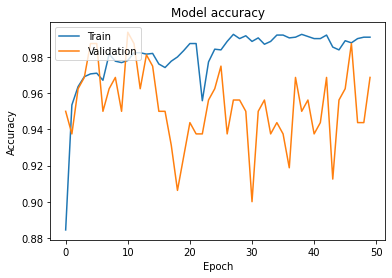

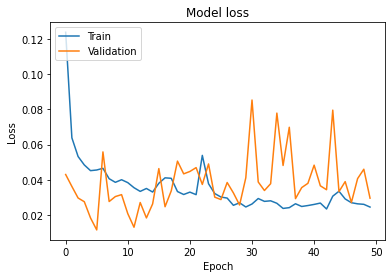

1/1 [==============================] - 0s 22ms/step
[[1.3944381]] [[0.00656211]]
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 200, 200, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_26 (Conv2D)             (None, 100, 100, 64  12608       ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 100, 100, 64  256        ['conv2d_26[0][0]']              
 rmalizatio

80/80 [==============================] - 118s 1s/step - loss: 0.2430 - accuracy: 0.7602 - val_loss: 0.1475 - val_accuracy: 0.8188
Epoch 2/50
80/80 [==============================] - ETA: 0s - loss: 0.0762 - accuracy: 0.9262

80/80 [==============================] - 104s 1s/step - loss: 0.0762 - accuracy: 0.9262 - val_loss: 0.0542 - val_accuracy: 0.9125
Epoch 3/50
80/80 [==============================] - 78s 983ms/step - loss: 0.0687 - accuracy: 0.9320 - val_loss: 0.0583 - val_accuracy: 0.9250
Epoch 4/50
80/80 [==============================] - ETA: 0s - loss: 0.0583 - accuracy: 0.9527

80/80 [==============================] - 103s 1s/step - loss: 0.0583 - accuracy: 0.9527 - val_loss: 0.0414 - val_accuracy: 0.9625
Epoch 5/50
80/80 [==============================] - 77s 978ms/step - loss: 0.0485 - accuracy: 0.9695 - val_loss: 0.0454 - val_accuracy: 0.9438
Epoch 6/50
80/80 [==============================] - 79s 994ms/step - loss: 0.0463 - accuracy: 0.9672 - val_loss: 0.0432 - val_accuracy: 0.9563
Epoch 7/50
80/80 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9688

80/80 [==============================] - 104s 1s/step - loss: 0.0468 - accuracy: 0.9688 - val_loss: 0.0373 - val_accuracy: 0.9625
Epoch 8/50
80/80 [==============================] - ETA: 0s - loss: 0.0439 - accuracy: 0.9684

80/80 [==============================] - 105s 1s/step - loss: 0.0439 - accuracy: 0.9684 - val_loss: 0.0371 - val_accuracy: 0.9563
Epoch 9/50
80/80 [==============================] - 78s 983ms/step - loss: 0.0436 - accuracy: 0.9703 - val_loss: 0.0516 - val_accuracy: 0.9250
Epoch 10/50
80/80 [==============================] - 79s 994ms/step - loss: 0.0427 - accuracy: 0.9695 - val_loss: 0.0664 - val_accuracy: 0.9125
Epoch 11/50
80/80 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.9656

80/80 [==============================] - 105s 1s/step - loss: 0.0441 - accuracy: 0.9656 - val_loss: 0.0349 - val_accuracy: 0.9625
Epoch 12/50
80/80 [==============================] - 78s 984ms/step - loss: 0.0365 - accuracy: 0.9770 - val_loss: 0.0383 - val_accuracy: 0.9625
Epoch 13/50
80/80 [==============================] - ETA: 0s - loss: 0.0354 - accuracy: 0.9785

80/80 [==============================] - 104s 1s/step - loss: 0.0354 - accuracy: 0.9785 - val_loss: 0.0339 - val_accuracy: 0.9563
Epoch 14/50
80/80 [==============================] - ETA: 0s - loss: 0.0321 - accuracy: 0.9805

80/80 [==============================] - 105s 1s/step - loss: 0.0321 - accuracy: 0.9805 - val_loss: 0.0309 - val_accuracy: 0.9688
Epoch 15/50
80/80 [==============================] - 78s 984ms/step - loss: 0.0348 - accuracy: 0.9734 - val_loss: 0.1015 - val_accuracy: 0.9062
Epoch 16/50
80/80 [==============================] - 77s 974ms/step - loss: 0.0364 - accuracy: 0.9746 - val_loss: 0.0315 - val_accuracy: 0.9688
Epoch 17/50
80/80 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9777

80/80 [==============================] - 104s 1s/step - loss: 0.0336 - accuracy: 0.9777 - val_loss: 0.0298 - val_accuracy: 0.9563
Epoch 18/50
80/80 [==============================] - 77s 977ms/step - loss: 0.0394 - accuracy: 0.9699 - val_loss: 0.0419 - val_accuracy: 0.9563
Epoch 19/50
80/80 [==============================] - 77s 978ms/step - loss: 0.0313 - accuracy: 0.9781 - val_loss: 0.0334 - val_accuracy: 0.9625
Epoch 20/50
80/80 [==============================] - 76s 966ms/step - loss: 0.0312 - accuracy: 0.9820 - val_loss: 0.0999 - val_accuracy: 0.9125
Epoch 21/50
80/80 [==============================] - 78s 979ms/step - loss: 0.0350 - accuracy: 0.9781 - val_loss: 0.0370 - val_accuracy: 0.9375
Epoch 22/50
80/80 [==============================] - 77s 973ms/step - loss: 0.0346 - accuracy: 0.9770 - val_loss: 0.0376 - val_accuracy: 0.9750
Epoch 23/50
80/80 [==============================] - 77s 970ms/step - loss: 0.0312 - accuracy: 0.9816 - val_loss: 0.0604 - val_accuracy: 0.9187
Epoch 

80/80 [==============================] - 104s 1s/step - loss: 0.0238 - accuracy: 0.9816 - val_loss: 0.0241 - val_accuracy: 0.9625
Epoch 40/50
80/80 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9801

80/80 [==============================] - 104s 1s/step - loss: 0.0238 - accuracy: 0.9801 - val_loss: 0.0229 - val_accuracy: 0.9750
Epoch 41/50
80/80 [==============================] - 77s 967ms/step - loss: 0.0252 - accuracy: 0.9762 - val_loss: 0.0333 - val_accuracy: 0.9625
Epoch 42/50
80/80 [==============================] - 77s 975ms/step - loss: 0.0232 - accuracy: 0.9836 - val_loss: 0.0582 - val_accuracy: 0.9187
Epoch 43/50
80/80 [==============================] - 77s 976ms/step - loss: 0.0221 - accuracy: 0.9824 - val_loss: 0.0348 - val_accuracy: 0.9563
Epoch 44/50
80/80 [==============================] - 77s 967ms/step - loss: 0.0224 - accuracy: 0.9809 - val_loss: 0.0464 - val_accuracy: 0.9438
Epoch 45/50
80/80 [==============================] - 77s 969ms/step - loss: 0.0224 - accuracy: 0.9812 - val_loss: 0.0501 - val_accuracy: 0.9312
Epoch 46/50
80/80 [==============================] - 77s 969ms/step - loss: 0.0230 - accuracy: 0.9848 - val_loss: 0.0419 - val_accuracy: 0.9375
Epoch 

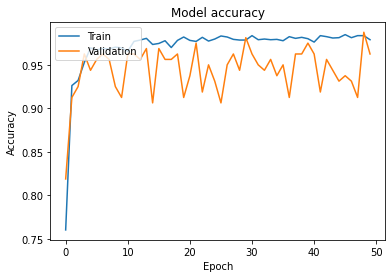

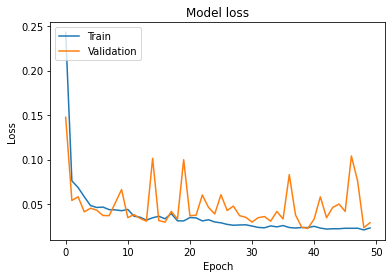

1/1 [==============================] - 0s 29ms/step
[[1.124792]] [[0.00309951]]
94765736/94765736 [==============================] - 3s 0us/step
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_10 (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_5 (Functional)           (None, 128)   

80/80 [==============================] - 93s 1s/step - loss: 0.0597 - accuracy: 0.9492 - val_loss: 0.0553 - val_accuracy: 0.9312
Epoch 2/50
80/80 [==============================] - ETA: 0s - loss: 0.0312 - accuracy: 0.9848

80/80 [==============================] - 78s 981ms/step - loss: 0.0312 - accuracy: 0.9848 - val_loss: 0.0354 - val_accuracy: 0.9750
Epoch 3/50
80/80 [==============================] - ETA: 0s - loss: 0.0260 - accuracy: 0.9895

80/80 [==============================] - 79s 991ms/step - loss: 0.0260 - accuracy: 0.9895 - val_loss: 0.0286 - val_accuracy: 0.9688
Epoch 4/50
80/80 [==============================] - 53s 658ms/step - loss: 0.0227 - accuracy: 0.9930 - val_loss: 0.0327 - val_accuracy: 0.9625
Epoch 5/50
80/80 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9934

80/80 [==============================] - 77s 964ms/step - loss: 0.0211 - accuracy: 0.9934 - val_loss: 0.0224 - val_accuracy: 0.9937
Epoch 6/50
80/80 [==============================] - 53s 659ms/step - loss: 0.0209 - accuracy: 0.9965 - val_loss: 0.0404 - val_accuracy: 0.9500
Epoch 7/50
80/80 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9969

80/80 [==============================] - 77s 972ms/step - loss: 0.0194 - accuracy: 0.9969 - val_loss: 0.0141 - val_accuracy: 0.9937
Epoch 8/50
80/80 [==============================] - 53s 660ms/step - loss: 0.0189 - accuracy: 0.9988 - val_loss: 0.0283 - val_accuracy: 0.9563
Epoch 9/50
80/80 [==============================] - 51s 642ms/step - loss: 0.0196 - accuracy: 0.9973 - val_loss: 0.0308 - val_accuracy: 0.9688
Epoch 10/50
80/80 [==============================] - 52s 646ms/step - loss: 0.0192 - accuracy: 0.9945 - val_loss: 0.0202 - val_accuracy: 0.9688
Epoch 11/50
80/80 [==============================] - 52s 646ms/step - loss: 0.0187 - accuracy: 0.9957 - val_loss: 0.0396 - val_accuracy: 0.9563
Epoch 12/50
80/80 [==============================] - 52s 649ms/step - loss: 0.0164 - accuracy: 0.9977 - val_loss: 0.0357 - val_accuracy: 0.9500
Epoch 13/50
80/80 [==============================] - 52s 647ms/step - loss: 0.0183 - accuracy: 0.9977 - val_loss: 0.0390 - val_accuracy: 0.9438
Epoch 

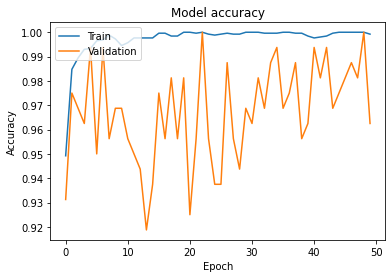

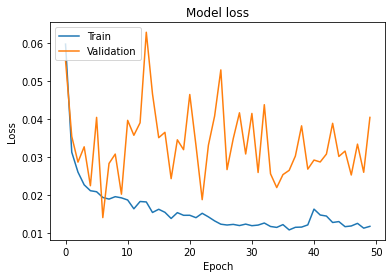

1/1 [==============================] - 0s 27ms/step
[[1.2968785]] [[0.0317115]]


In [ ]:
f10 = faceid_beta()
x = f10.show_graph()
cop1 = f10.create_wrong_rgbd('val')
cop2 = f10.create_couple_rgbd('val')
outputs1 = x.predict([cop1[0].reshape((1,200,200,4)), cop1[1].reshape((1,200,200,4))])
outputs2 = x.predict([cop2[0].reshape((1,200,200,4)), cop2[1].reshape((1,200,200,4))])
print(outputs1, outputs2)

f11 = faceid_v1_1()
x = f11.show_graph()
cop1 = f11.create_wrong_rgbd('val')
cop2 = f11.create_couple_rgbd('val')
outputs1 = x.predict([cop1[0].reshape((1,200,200,4)), cop1[1].reshape((1,200,200,4))])
outputs2 = x.predict([cop2[0].reshape((1,200,200,4)), cop2[1].reshape((1,200,200,4))])
print(outputs1, outputs2)

f12 = faceid_v1_2()
x = f12.show_graph()
cop1 = f12.create_wrong_rgbd('val')
cop2 = f12.create_couple_rgbd('val')
outputs1 = x.predict([cop1[0].reshape((1,200,200,3)), cop1[1].reshape((1,200,200,3))])
outputs2 = x.predict([cop2[0].reshape((1,200,200,3)), cop2[1].reshape((1,200,200,3))])
print(outputs1, outputs2)

In [1]:
# f10 = faceid_beta()
# goo_cop1 = f10.create_wrong_rgbd('val')
# goo_cop2 = f10.create_couple_rgbd('val')
# res_cop1 = np.zeros((2,200,200,3))
# res_cop2 = np.zeros((2,200,200,3))
# res_cop1 = goo_cop1[:,:,:,:3]
# res_cop2 = goo_cop2[:,:,:,:3]
# plt.subplots_adjust(wspace=0, hspace=0)
# # wrong
# plt.subplot(2,2,1)
# plt.imshow(res_cop1[0].astype(np.int64))
# plt.axis('off')
# plt.subplot(2,2,2)
# plt.imshow(res_cop2[0].astype(np.int64))
# plt.axis('off')
# # right
# plt.subplot(2,2,3)
# plt.imshow(res_cop1[1].astype(np.int64))
# plt.axis('off')
# plt.subplot(2,2,4)
# plt.imshow(res_cop2[1].astype(np.int64))
# plt.axis('off')